In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [13]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-1.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])

In [14]:
df.head()

,temp,hum,co,no2,pm2_5,pm10,date
0,15,50,40,1.31,53,74,2020-01-11 17:08:19
1,15,50,40,1.32,53,74,2020-01-11 17:08:13
2,15,50,40,1.32,53,74,2020-01-11 17:08:09
3,15,50,40,1.32,53,74,2020-01-11 17:08:03
4,15,50,40,1.32,53,74,2020-01-11 17:07:59


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872050 entries, 0 to 872049
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   temp    872050 non-null  int64         
 1   hum     872050 non-null  int64         
 2   co      872050 non-null  int64         
 3   no2     872050 non-null  float64       
 4   pm2_5   872050 non-null  int64         
 5   pm10    872050 non-null  int64         
 6   date    872050 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 46.6 MB


In [16]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [17]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 11:00:00,20.72,45.55,5.50,19.41,20.07,28.07
2019-09-13 12:00:00,21.68,45.55,5.22,19.42,21.99,30.39
2019-09-13 13:00:00,22.19,43.53,5.67,19.43,22.63,31.49
2019-09-13 14:00:00,21.73,44.27,4.93,19.42,24.61,34.45
2019-09-13 15:00:00,19.29,54.04,6.34,19.40,28.56,39.77
...,...,...,...,...,...,...
2020-01-11 13:00:00,17.92,44.29,40.00,1.38,66.62,92.64
2020-01-11 14:00:00,17.50,42.56,40.00,1.41,57.87,80.33
2020-01-11 15:00:00,16.74,44.00,40.00,1.45,53.99,74.98


In [18]:
pm = one_hr_sample[['PM2.5']].copy()

In [19]:
pm

,PM2.5
date,
2019-09-13 11:00:00,20.07
2019-09-13 12:00:00,21.99
2019-09-13 13:00:00,22.63
2019-09-13 14:00:00,24.61
2019-09-13 15:00:00,28.56
...,...
2020-01-11 13:00:00,66.62
2020-01-11 14:00:00,57.87
2020-01-11 15:00:00,53.99


In [20]:
df = pm.copy()

In [21]:
df = df[-744:]
df

,PM2.5
date,
2019-12-11 18:00:00,215.85
2019-12-11 19:00:00,173.68
2019-12-11 20:00:00,181.77
2019-12-11 21:00:00,226.29
2019-12-11 22:00:00,231.47
...,...
2020-01-11 13:00:00,66.62
2020-01-11 14:00:00,57.87
2020-01-11 15:00:00,53.99


In [22]:
df.isna().sum()

PM2.5    226
dtype: int64

In [23]:
df = df.interpolate(method ='linear')

<AxesSubplot:xlabel='date'>

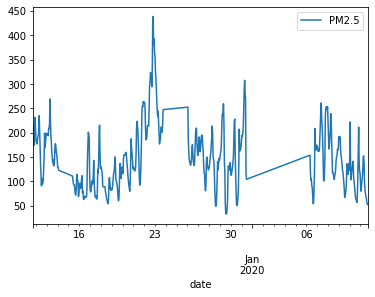

In [24]:
df.plot()

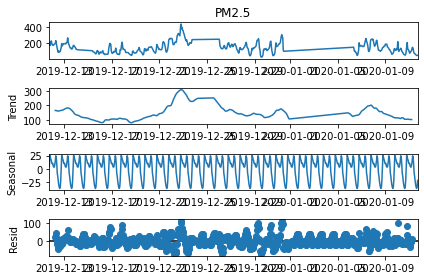

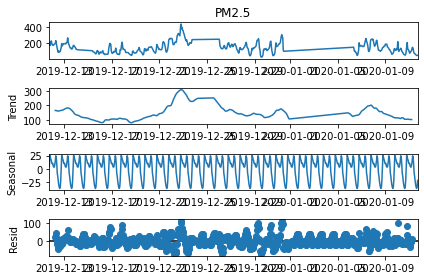

In [25]:
results = seasonal_decompose(df['PM2.5'], freq=24)
results.plot()

In [26]:
len(df)

744

In [27]:
train = df.iloc[:720]
test = df.iloc[720:]

scaler = MinMaxScaler()

In [28]:
df.head(), df.tail()

(                      PM2.5
 date                       
 2019-12-11 18:00:00  215.85
 2019-12-11 19:00:00  173.68
 2019-12-11 20:00:00  181.77
 2019-12-11 21:00:00  226.29
 2019-12-11 22:00:00  231.47,
                      PM2.5
 date                      
 2020-01-11 13:00:00  66.62
 2020-01-11 14:00:00  57.87
 2020-01-11 15:00:00  53.99
 2020-01-11 16:00:00  52.26
 2020-01-11 17:00:00  53.56)

In [29]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.45110426],
       [0.34704503],
       [0.36700802],
       [0.47686613],
       [0.48964837],
       [0.42292412],
       [0.36809377],
       [0.36394818],
       [0.3545219 ],
       [0.37399136]])

# Recursive Strategy

In [30]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.45110426],
         [0.34704503],
         [0.36700802],
         [0.47686613],
         [0.48964837],
         [0.42292412],
         [0.36809377],
         [0.36394818],
         [0.3545219 ],
         [0.37399136],
         [0.38867366],
         [0.40192474],
         [0.41379395],
         [0.49769278],
         [0.42776064],
         [0.34322023],
         [0.25655768],
         [0.19237508],
         [0.1436644 ],
         [0.18033313],
         [0.15272054],
         [0.15698951],
         [0.16945096],
         [0.2274892 ]]]),
 array([[0.29325108]]))

In [31]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(generator, epochs=10, verbose=1)

Epoch 1/10
696/696 [==============================] - 35s 10ms/step - loss: 0.0149
Epoch 2/10
696/696 [==============================] - 7s 10ms/step - loss: 0.0049
Epoch 3/10
696/696 [==============================] - 7s 10ms/step - loss: 0.0042
Epoch 4/10
696/696 [==============================] - 7s 10ms/step - loss: 0.0026
Epoch 5/10
696/696 [==============================] - 7s 11ms/step - loss: 0.0023
Epoch 6/10
696/696 [==============================] - 8s 11ms/step - loss: 0.0020
Epoch 7/10
696/696 [==============================] - 9s 13ms/step - loss: 0.0019
Epoch 8/10
696/696 [==============================] - 8s 11ms/step - loss: 0.0020
Epoch 9/10
696/696 [==============================] - 7s 11ms/step - loss: 0.0026
Epoch 10/10
696/696 [==============================] - ETA: 0s - loss: 0.003 - 8s 11ms/step - loss: 0.0035


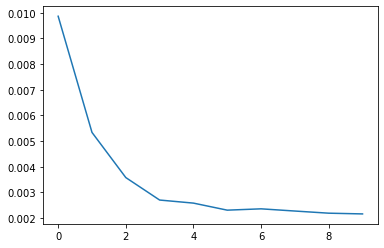

In [33]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [34]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.08317323]], dtype=float32)

In [35]:
scaled_test[0], scaled_test[1]

(array([0.17645898]), array([0.32542875]))

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.08317323], dtype=float32),
 array([0.07733886], dtype=float32),
 array([0.06833486], dtype=float32),
 array([0.05808968], dtype=float32),
 array([0.04758457], dtype=float32),
 array([0.03743706], dtype=float32),
 array([0.02792315], dtype=float32),
 array([0.01913455], dtype=float32),
 array([0.01110186], dtype=float32),
 array([0.00381548], dtype=float32),
 array([-0.00270431], dtype=float32),
 array([-0.00843843], dtype=float32),
 array([-0.01341356], dtype=float32),
 array([-0.01763479], dtype=float32),
 array([-0.02104816], dtype=float32),
 array([-0.02371966], dtype=float32),
 array([-0.02575372], dtype=float32),
 array([-0.02716417], dtype=float32),
 array([-0.02797006], dtype=float32),
 array([-0.02819784], dtype=float32),
 array([-0.02792051], dtype=float32),
 array([-0.02721172], dtype=float32),
 array([-0.02615545], dtype=float32),
 array([-0.02485398], dtype=float32)]

In [37]:
test.head()

,PM2.5
date,
2020-01-10 18:00:00,104.55
2020-01-10 19:00:00,164.92
2020-01-10 20:00:00,211.35
2020-01-10 21:00:00,141.20
2020-01-10 22:00:00,121.06


In [38]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

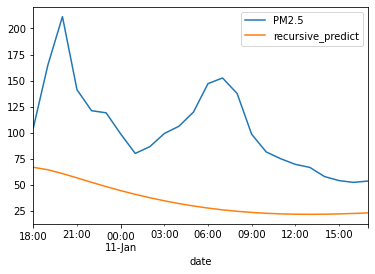

In [39]:
test.plot()

In [40]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['recursive_predict']))
print(rmse)

76.17475803262796


In [41]:
test

,PM2.5,recursive_predict
date,,
2020-01-10 18:00:00,104.55,66.745952
2020-01-10 19:00:00,164.92,64.381573
2020-01-10 20:00:00,211.35,60.732703
2020-01-10 21:00:00,141.20,56.580843
2020-01-10 22:00:00,121.06,52.323649
2020-01-10 23:00:00,119.04,48.211370
2020-01-11 00:00:00,98.77,44.355858
2020-01-11 01:00:00,80.07,40.794275
2020-01-11 02:00:00,86.52,37.539029


# Direct Startegy

In [42]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [43]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [44]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.18581328], dtype=float32),
 array([0.18495882], dtype=float32),
 array([0.19993412], dtype=float32),
 array([0.18345244], dtype=float32),
 array([0.20755693], dtype=float32),
 array([0.21005793], dtype=float32),
 array([0.18150502], dtype=float32),
 array([0.20041227], dtype=float32),
 array([0.18457158], dtype=float32),
 array([0.20452358], dtype=float32),
 array([0.21608919], dtype=float32),
 array([0.19580926], dtype=float32),
 array([0.23126024], dtype=float32),
 array([0.17971168], dtype=float32),
 array([0.20914222], dtype=float32),
 array([0.20000617], dtype=float32),
 array([0.20226696], dtype=float32),
 array([0.1925233], dtype=float32),
 array([0.18046525], dtype=float32),
 array([0.1923417], dtype=float32),
 array([0.16128123], dtype=float32),
 array([0.17900914], dtype=float32),
 array([0.19741112], dtype=float32),
 array([0.18692552], dtype=float32)]

In [45]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

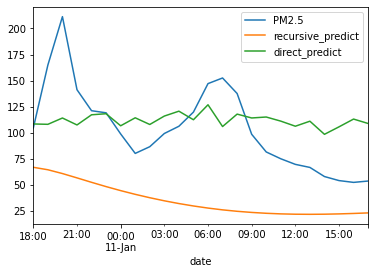

In [46]:
test.plot()

In [47]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_predict']))
print(rmse)

38.79222450750476


In [48]:
test

,PM2.5,recursive_predict,direct_predict
date,,,
2020-01-10 18:00:00,104.55,66.745952,108.340831
2020-01-10 19:00:00,164.92,64.381573,107.994560
2020-01-10 20:00:00,211.35,60.732703,114.063304
2020-01-10 21:00:00,141.20,56.580843,107.384102
2020-01-10 22:00:00,121.06,52.323649,117.152447
2020-01-10 23:00:00,119.04,48.211370,118.165976
2020-01-11 00:00:00,98.77,44.355858,106.594911
2020-01-11 01:00:00,80.07,40.794275,114.257074
2020-01-11 02:00:00,86.52,37.539029,107.837632


# Direct Recursive Startegy

In [49]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [50]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [51]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.16197288], dtype=float32),
 array([0.17858016], dtype=float32),
 array([0.17302358], dtype=float32),
 array([0.16714299], dtype=float32),
 array([0.18923494], dtype=float32),
 array([0.19718002], dtype=float32),
 array([0.20354964], dtype=float32),
 array([0.19522564], dtype=float32),
 array([0.21561992], dtype=float32),
 array([0.20246167], dtype=float32),
 array([0.21147944], dtype=float32),
 array([0.20290236], dtype=float32),
 array([0.19373295], dtype=float32),
 array([0.21246123], dtype=float32),
 array([0.22285679], dtype=float32),
 array([0.23515286], dtype=float32),
 array([0.23571382], dtype=float32),
 array([0.2247427], dtype=float32),
 array([0.21902855], dtype=float32),
 array([0.21695192], dtype=float32),
 array([0.21924327], dtype=float32),
 array([0.20950727], dtype=float32),
 array([0.22242975], dtype=float32),
 array([0.23055227], dtype=float32)]

In [52]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

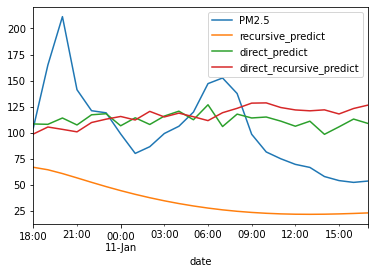

In [53]:
test.plot()

In [54]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_recursive_predict']))
print(rmse)

46.67889178243332


In [55]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict
date,,,,
2020-01-10 18:00:00,104.55,66.745952,108.340831,98.679510
2020-01-10 19:00:00,164.92,64.381573,107.994560,105.409612
2020-01-10 20:00:00,211.35,60.732703,114.063304,103.157806
2020-01-10 21:00:00,141.20,56.580843,107.384102,100.774696
2020-01-10 22:00:00,121.06,52.323649,117.152447,109.727460
2020-01-10 23:00:00,119.04,48.211370,118.165976,112.947202
2020-01-11 00:00:00,98.77,44.355858,106.594911,115.528491
2020-01-11 01:00:00,80.07,40.794275,114.257074,112.155191
2020-01-11 02:00:00,86.52,37.539029,107.837632,120.419973


# MIMO

In [56]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [57]:
n_input = 24
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [58]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [59]:
model.fit(X, y, epochs=3, verbose=0)

In [60]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_49 (Dense)             (None, 24)                4824      
Total params: 166,424
Trainable params: 166,424
Non-trainable params: 0
_________________________________________________________________


In [61]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [62]:
res.shape

(24, 1)

In [63]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [64]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
date,,,,,
2020-01-10 18:00:00,104.55,66.745952,108.340831,98.679510,134.397842
2020-01-10 19:00:00,164.92,64.381573,107.994560,105.409612,129.340073
2020-01-10 20:00:00,211.35,60.732703,114.063304,103.157806,129.658905
2020-01-10 21:00:00,141.20,56.580843,107.384102,100.774696,136.322266
2020-01-10 22:00:00,121.06,52.323649,117.152447,109.727460,129.196533
2020-01-10 23:00:00,119.04,48.211370,118.165976,112.947202,132.671356
2020-01-11 00:00:00,98.77,44.355858,106.594911,115.528491,131.840439
2020-01-11 01:00:00,80.07,40.794275,114.257074,112.155191,135.598434
2020-01-11 02:00:00,86.52,37.539029,107.837632,120.419973,130.972626


<AxesSubplot:xlabel='date'>

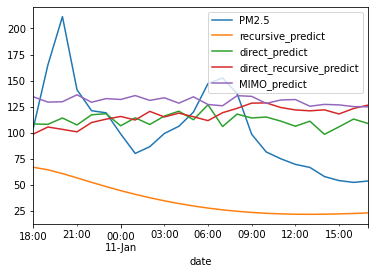

In [65]:
test.plot()

In [66]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['MIMO_predict']))
print(rmse)

46.859559742484194


# Direct MIMO

In [67]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [68]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [70]:
n_input = 12
n_features = 1
test_predictions = []

n_output = 6

q = int(len(scaled_test)/n_output)


for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.21694164, 0.22533119, 0.22838312, 0.21442744, 0.2348451 ,
         0.24214786]], dtype=float32),
 array([[0.21965382, 0.2123121 , 0.21357262, 0.22599857, 0.22391811,
         0.23134787]], dtype=float32),
 array([[0.21950829, 0.21704109, 0.22087887, 0.20961821, 0.21905413,
         0.19842863]], dtype=float32),
 array([[0.22226661, 0.20567565, 0.20023647, 0.19364133, 0.18649538,
         0.20641494]], dtype=float32)]

In [71]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [72]:
res = np.array(res)
res = res.reshape((res.shape[0],1))
res.shape

(24, 1)

In [73]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [74]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
date,,,,,,
2020-01-10 18:00:00,104.55,66.745952,108.340831,98.679510,134.397842,120.955605
2020-01-10 19:00:00,164.92,64.381573,107.994560,105.409612,129.340073,124.355461
2020-01-10 20:00:00,211.35,60.732703,114.063304,103.157806,129.658905,125.592262
2020-01-10 21:00:00,141.20,56.580843,107.384102,100.774696,136.322266,119.936722
2020-01-10 22:00:00,121.06,52.323649,117.152447,109.727460,129.196533,128.210983
2020-01-10 23:00:00,119.04,48.211370,118.165976,112.947202,132.671356,131.170425
2020-01-11 00:00:00,98.77,44.355858,106.594911,115.528491,131.840439,122.054710
2020-01-11 01:00:00,80.07,40.794275,114.257074,112.155191,135.598434,119.079475
2020-01-11 02:00:00,86.52,37.539029,107.837632,120.419973,130.972626,119.590302


<AxesSubplot:xlabel='date'>

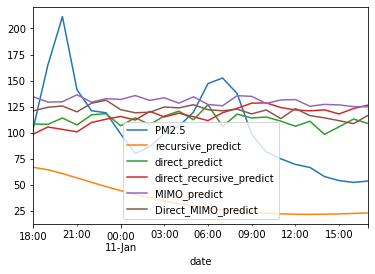

In [75]:
test.plot()

In [76]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['Direct_MIMO_predict']))
print(rmse)

40.005612512275356


In [77]:
rec_err = abs(test['PM2.5'] - test['recursive_predict'])
dir_err = abs(test['PM2.5'] - test['direct_predict'])
dir_rec_err = abs(test['PM2.5'] - test['direct_recursive_predict'])
mimo_err = abs(test['PM2.5'] - test['MIMO_predict'])
dir_mimo_err = abs(test['PM2.5'] - test['Direct_MIMO_predict'])

In [78]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [79]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
date,,,,,
2020-01-10 18:00:00,37.804048,3.790831,5.870490,29.847842,16.405605
2020-01-10 19:00:00,100.538427,56.925440,59.510388,35.579927,40.564539
2020-01-10 20:00:00,150.617297,97.286696,108.192194,81.691095,85.757738
2020-01-10 21:00:00,84.619157,33.815898,40.425304,4.877734,21.263278
2020-01-10 22:00:00,68.736351,3.907553,11.332540,8.136533,7.150983
2020-01-10 23:00:00,70.828630,0.874024,6.092798,13.631356,12.130425
2020-01-11 00:00:00,54.414142,7.824911,16.758491,33.070439,23.284710
2020-01-11 01:00:00,39.275725,34.187074,32.085191,55.528434,39.009475
2020-01-11 02:00:00,48.980971,21.317632,33.899973,44.452626,33.070302


<AxesSubplot:xlabel='date'>

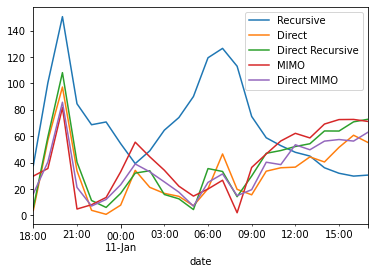

In [80]:
errors.plot()

In [81]:
len(scaled_test)

24